In [1]:
#!pip install tensorflow roboflow gradio

In [2]:
from roboflow import Roboflow

rf = Roboflow(api_key="Ad2r9VyScPoX0wQc3iPo")
project = rf.workspace("gregory-alan-uhland-jr").project("lionfish-k1zkz")
version = project.version(3)
dataset = version.download("tfrecord")

loading Roboflow workspace...
loading Roboflow project...


In [3]:
import tensorflow as tf
import numpy as np
import gradio as gr
from tensorflow.keras.applications import Xception, VGG16, VGG19
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import logging

logging.basicConfig(level=logging.ERROR)

# Paths to TFRecord files
train_tfrecord = os.path.join(dataset.location, 'train', 'Fish.tfrecord')
valid_tfrecord = os.path.join(dataset.location, 'valid', 'Fish.tfrecord')
test_tfrecord = os.path.join(dataset.location, 'test', 'Fish.tfrecord')

# Check if the files exist
if not os.path.exists(train_tfrecord):
    logging.error(f"Train TFRecord not found: {train_tfrecord}")
if not os.path.exists(valid_tfrecord):
    logging.error(f"Validation TFRecord not found: {valid_tfrecord}")
if not os.path.exists(test_tfrecord):
    logging.error(f"Test TFRecord not found: {test_tfrecord}")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [4]:
def parse_tfrecord_fn(example):
    feature_description = {
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/format': tf.io.FixedLenFeature([], tf.string),
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/object/class/label': tf.io.VarLenFeature(tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example['image/encoded'], channels=3)
    image = tf.image.resize(image, [270, 480])
    image = image / 255.0  # Normalize image data

    label = tf.sparse.to_dense(example['image/object/class/label'], default_value=-1)
    label = tf.reduce_max(label)
    label = tf.cast(label > 0, tf.int64)
    
    return image, label

def augment_image(image, label):
    # Apply random augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

def load_tfrecord_dataset(filenames, batch_size=32, shuffle_buffer_size=1024, repeat=True, augment=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(parse_tfrecord_fn)
    if augment:
        dataset = dataset.map(augment_image)
    dataset = dataset.shuffle(buffer_size=shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    if repeat:
        dataset = dataset.repeat()
    return dataset

# Load datasets with updated parsing function
batch_size = 128
train_dataset = load_tfrecord_dataset(train_tfrecord, batch_size=batch_size, repeat=True)
valid_dataset = load_tfrecord_dataset(valid_tfrecord, batch_size=batch_size, repeat=True)
test_dataset = load_tfrecord_dataset(test_tfrecord, batch_size=batch_size, repeat=False)

In [5]:
def create_xception_model():
    base_model = Xception(weights='imagenet', include_top=False, input_shape=(270, 480, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)  # Define the model here
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

xception_model = create_xception_model()

In [6]:
def create_vgg16_model():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(270, 480, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)  # Define the model here
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg16_model = create_vgg16_model()

In [7]:
def create_vgg19_model():
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(270, 480, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)  # Define the model here
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

vgg19_model = create_vgg19_model()

In [8]:
def create_custom_model():
    model = Sequential([
        Input(shape=(480, 270, 3)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, clipvalue=1.0)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

custom_model = create_custom_model()

Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.5406 - loss: 0.6800 - val_accuracy: 0.8144 - val_loss: 0.5536
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7339 - loss: 0.6125 - val_accuracy: 0.8144 - val_loss: 0.4963
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7397 - loss: 0.5628 - val_accuracy: 0.8144 - val_loss: 0.4736
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7774 - loss: 0.5196 - val_accuracy: 0.8144 - val_loss: 0.4645
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7749 - loss: 0.5356 - val_accuracy: 0.8144 - val_loss: 0.4618
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7185 - loss: 0.5740 - val_accuracy: 0.8144 - val_loss: 0.4623
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7274 - loss: 0.5775 - val_accuracy: 0.8144 - val_loss: 0.4612
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.7491 - loss: 0.5443 - val_accuracy: 0.8144 - val_loss:

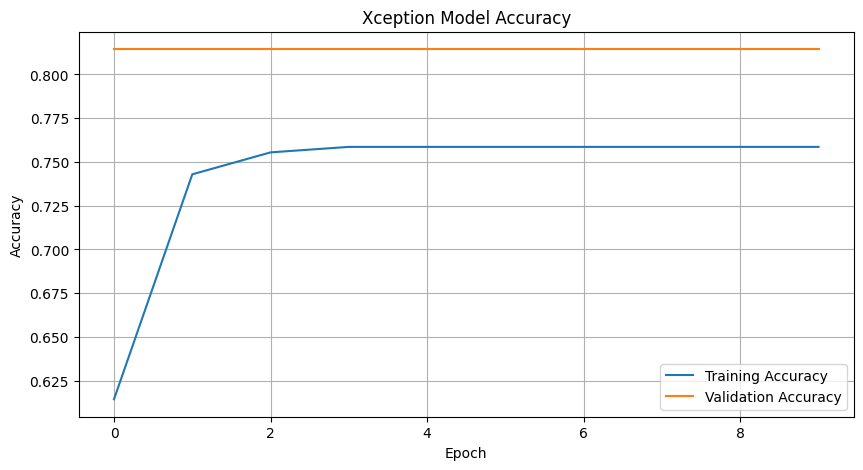

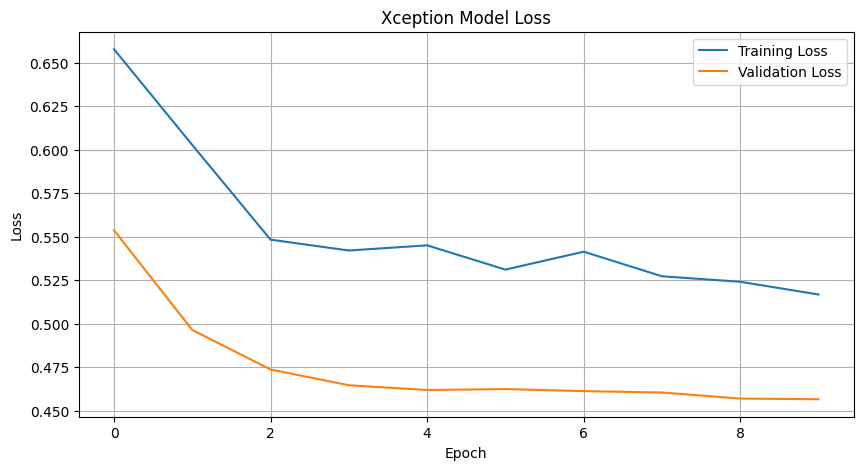

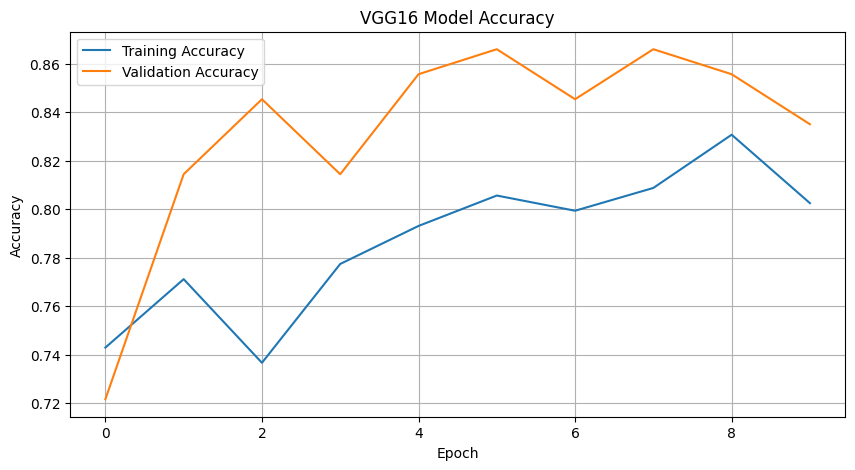

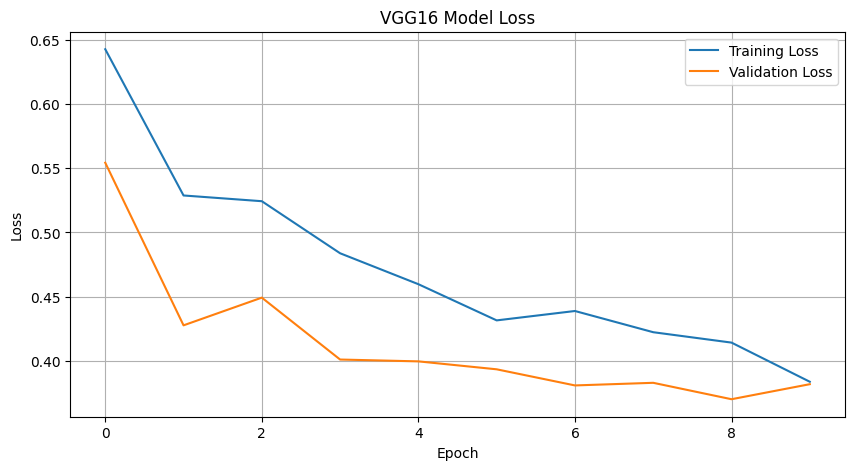

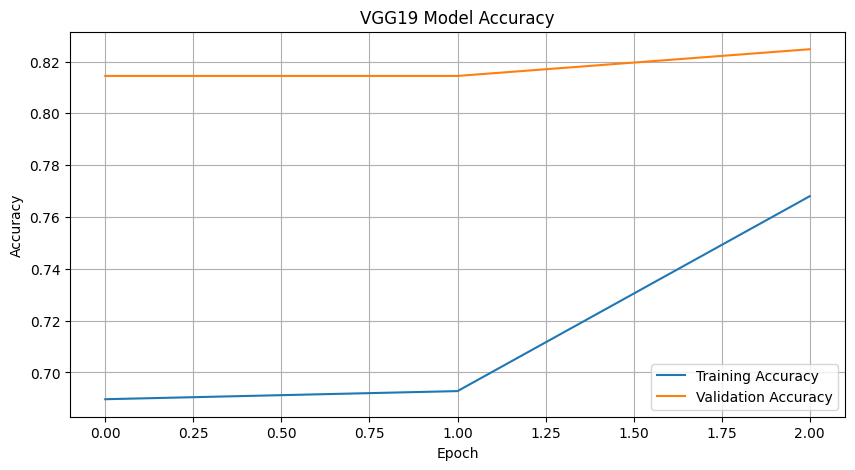

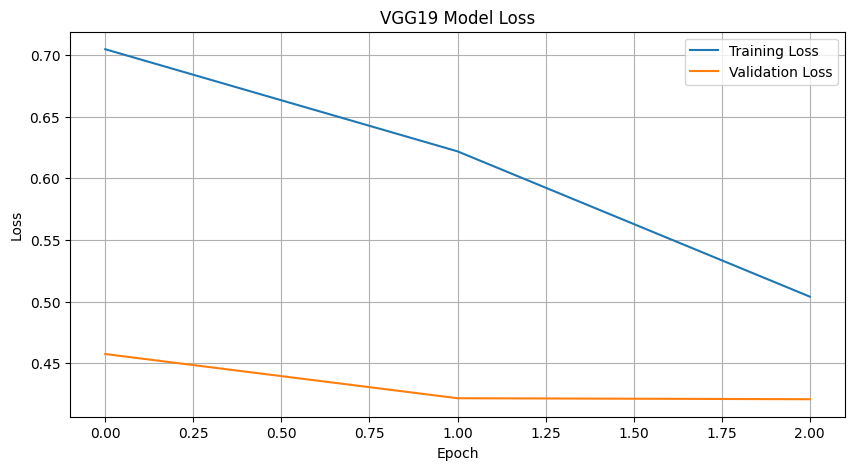

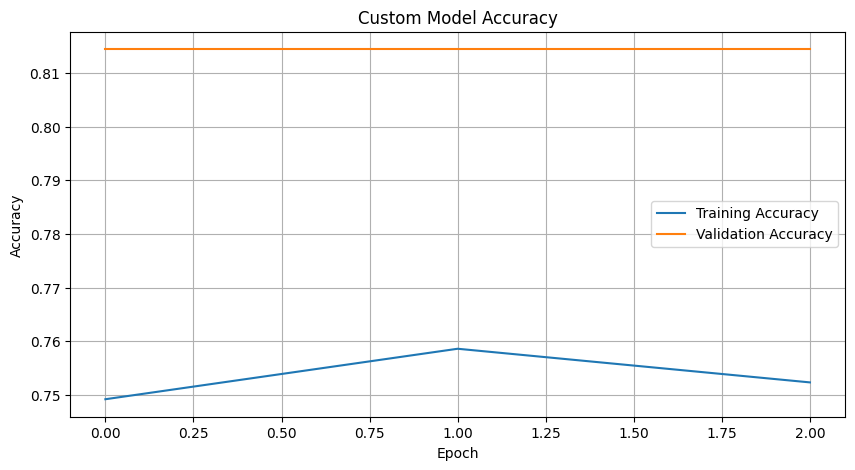

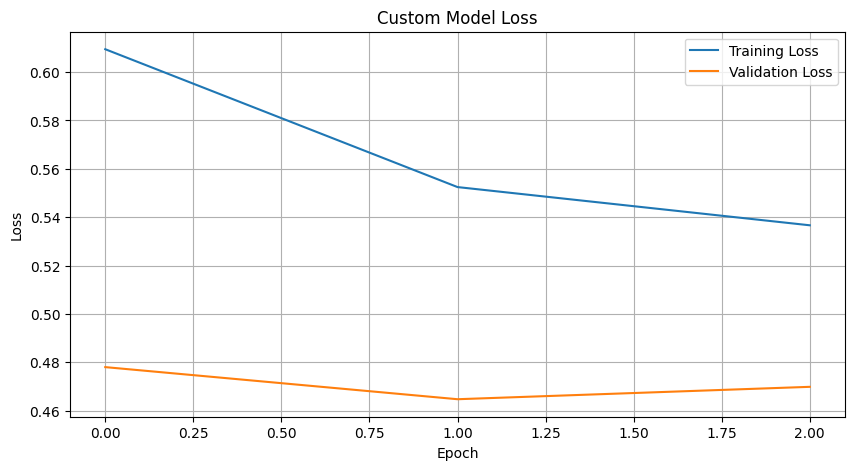

In [9]:
import math
import logging
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Define batch size
batch_size = 32

# Define steps per epoch
train_steps = math.ceil(319 / batch_size)
valid_steps = math.ceil(97 / batch_size)

# Define LoggingCallback to detect NaN values
class LoggingCallback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs=None):
        if np.isnan(logs.get('loss')):
            logging.error(f"NaN loss detected at batch {batch}")
            self.model.stop_training = True

# Define callbacks
callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    LoggingCallback()
]

# Load datasets with augmentation for training
train_dataset = load_tfrecord_dataset(train_tfrecord, batch_size=batch_size, repeat=True, augment=True)
valid_dataset = load_tfrecord_dataset(valid_tfrecord, batch_size=batch_size, repeat=True)
test_dataset = load_tfrecord_dataset(test_tfrecord, batch_size=batch_size, repeat=False)

# Train models with additional logging
history_xception = None
history_vgg16 = None
history_vgg19 = None
history_custom = None

try:
    history_xception = xception_model.fit(train_dataset, validation_data=valid_dataset, epochs=10, steps_per_epoch=train_steps, validation_steps=valid_steps, callbacks=callbacks)
except Exception as e:
    logging.error(f"Error training Xception model: {e}")

try:
    history_vgg16 = vgg16_model.fit(train_dataset, validation_data=valid_dataset, epochs=10, steps_per_epoch=train_steps, validation_steps=valid_steps, callbacks=callbacks)
except Exception as e:
    logging.error(f"Error training VGG16 model: {e}")

try:
    history_vgg19 = vgg19_model.fit(train_dataset, validation_data=valid_dataset, epochs=10, steps_per_epoch=train_steps, validation_steps=valid_steps, callbacks=callbacks)
except Exception as e:
    logging.error(f"Error training VGG19 model: {e}")

try:
    history_custom = custom_model.fit(train_dataset, validation_data=valid_dataset, epochs=10, steps_per_epoch=train_steps, validation_steps=valid_steps, callbacks=callbacks)
except Exception as e:
    logging.error(f"Error training custom model: {e}")

# Function to plot accuracy
def plot_accuracy(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to plot loss
def plot_loss(history, model_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting accuracy and loss for each model
if history_xception:
    plot_accuracy(history_xception, 'Xception')
    plot_loss(history_xception, 'Xception')

if history_vgg16:
    plot_accuracy(history_vgg16, 'VGG16')
    plot_loss(history_vgg16, 'VGG16')

if history_vgg19:
    plot_accuracy(history_vgg19, 'VGG19')
    plot_loss(history_vgg19, 'VGG19')

if history_custom:
    plot_accuracy(history_custom, 'Custom')
    plot_loss(history_custom, 'Custom')

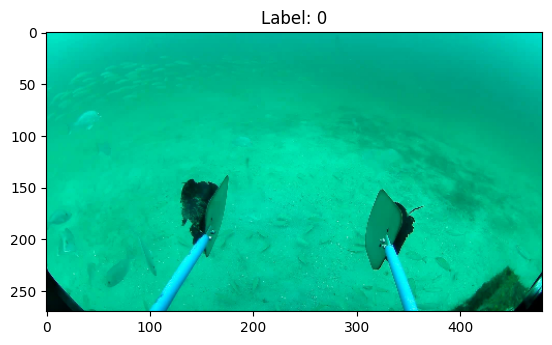

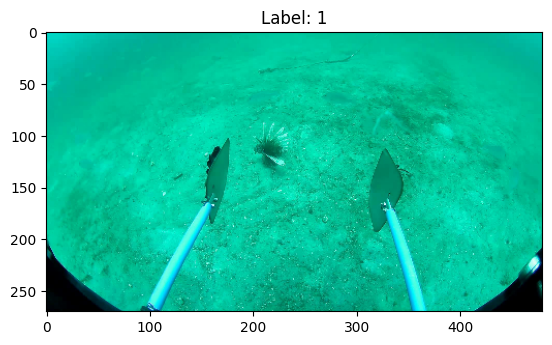

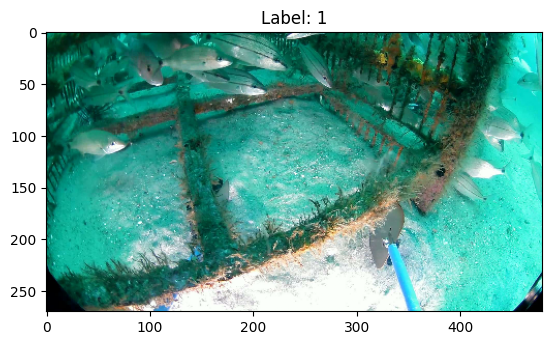

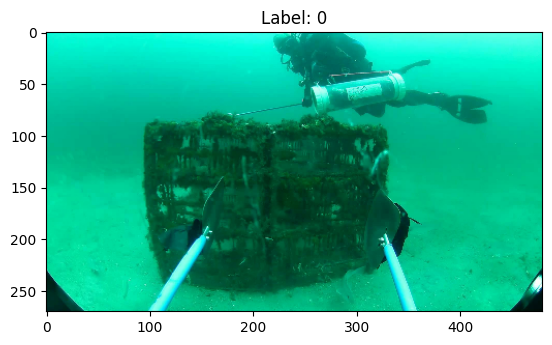

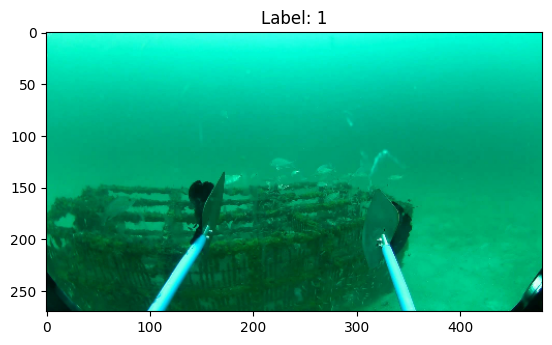

2024-08-03 19:07:13.057206: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
import matplotlib.pyplot as plt
def visualize_data(dataset, num_samples=5):
    for images, labels in dataset.take(1):
        for i in range(num_samples):
            img_array = images[i].numpy()
            label = labels[i].numpy()
            plt.imshow(img_array)
            plt.title(f"Label: {label}")
            plt.show()

# Visualize training data
visualize_data(test_dataset)


In [16]:
import gradio as gr
from PIL import Image
import numpy as np

def predict_image(image, model, model_name):
    # Ensure the image is a PIL image
    if not isinstance(image, Image.Image):
        image = Image.fromarray(image)
    image = image.resize((480, 270))  # Resize using PIL
    img_array = np.array(image) / 255.0  # Convert to numpy array and normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    prediction = model.predict(img_array)
    print(f"Raw prediction for {model_name}: {prediction[0]}")  # Print the raw prediction value
    return f'Lionfish - {prediction[0]}' if prediction[0] > 0.70 else f'Not Lionfish - {prediction[0]}'

def predict(image):
    results = {}
    results["Xception"] = predict_image(image, xception_model, "Xception")
    results["VGG16"] = predict_image(image, vgg16_model, "VGG16")
    results["VGG19"] = predict_image(image, vgg19_model, "VGG19")
    results["Custom"] = predict_image(image, custom_model, "Custom")
    return results

image_input = gr.Image()
label_output = gr.JSON()  # Use JSON to display dictionary results

gr.Interface(fn=predict, inputs=image_input, outputs=label_output).launch()

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
Raw prediction for Xception: [0.6740185]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Raw prediction for VGG16: [0.66254824]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
Raw prediction for VGG19: [0.5772825]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Raw prediction for Custom: [0.77044386]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Raw prediction for Xception: [0.73390967]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Raw prediction for VGG16: [0.6271987]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Raw prediction for VGG19: [0.71256876]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Raw prediction for Custom: [0.8509887]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Raw prediction for Xception: [0.8642064]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Raw prediction for VGG16: [0.92192966]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Raw prediction for VGG19: [0.7462064]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Raw prediction for Custom: [0.7963262]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Raw prediction for Xcep